In [1]:
from __future__ import print_function
from f4klib2 import *
import seaborn as sns
movs = loadMovids()
movs_length = loadLengths()

In [2]:
def getValidationResult(split = None):
    
    idl = np.array([396853,396857,396859,396860,396866,396876,396880,396892,396895,396900,
                    396823,396829,396843,396852,396862,396870,396882,396885,396889,396894,
                    396856,396863,396864,396868,396869,396893,396896,396897,396898,396899,
                    396624,396639,396662,396675,396728,396737,396759,396777,396790,396804,
                    396750,396760,396767,396784,396792,396793,396872,396877,396878,396886,
                    396824,396836,396839,396854,396858,396861,396865,396871,396874,396884,
                    396720,396733,396778,396815,396820,396827,396830,396834,396879,396890,
                    396840,396841,396845,396849,396850,396851,396867,396883,396887,396891,
                    396785,396802,396811,396822,396838,396844,396873,396875,396881,396888])

    if split != None:
        idl = idl.reshape(-1,2)[:,split-1]
        
    location = "/afs/inf.ed.ac.uk/group/project/F4KC/output/{0}/{1}/{2}.YHAT.npy"
    start = True

    for i in idl:
        idee = movs[i][0]
        length = movs_length[i]
        spacing = 1
        if length >= 200:
            spacing = length/100
        yhat = np.load(location.format(idee[0],idee[0:2],idee))
        gts = loadNewGT(idee, movs_length[i],validation=True,spacing=spacing)
        gts = np.array(gts)
        mask = gts != None
        yhat = yhat[mask]
        gts = gts[mask]

        if start:
            yhats = yhat
            targets = gts
            start = False
        else:
            yhats = np.vstack((yhats,yhat))
            targets = np.hstack((targets,gts))

    mask = targets != 0
    yhats = yhats[mask]
    targets = targets[mask]

    #yhats = yhats.reshape(-1,40)
    targets = targets.astype(int)

    return (yhats,targets)

In [3]:
def getWeightedVote(vec,keptRange,lim=0.5):
    return np.sum(vec[np.array(keptRange)-1])>=lim

def vote(yhats,targets,svm=True,cnn=True,cnnwc=True,cnnbc=True,minvote=1,keptRange=[6,7,8],lim=0.5, ret=False):
    
    l = len(targets)
    #result = np.argmax(yhats,2) + 1
    
    binary = [False] * l
    summu = np.sum(yhats,1)[:,6]>=3.999
    summu2 = np.sum(yhats,1)[:,1]>=3.999
    for i in range(l):
        #FEIF
        if summu[i] or summu2[i]:
            continue
            
        count = 0
        #if svm   and (result[i,0] in keptRange): count+=1
        #if cnn   and (result[i,1] in keptRange): count+=1
        #if cnnwc and (result[i,2] in keptRange): count+=1
        #if cnnbc and (result[i,3] in keptRange): count+=1
        if svm   and getWeightedVote(yhats[i,0,:],keptRange=keptRange,lim=lim): count+=1
        if cnn   and getWeightedVote(yhats[i,1,:],keptRange=keptRange,lim=lim): count+=1
        if cnnwc and getWeightedVote(yhats[i,2,:],keptRange=keptRange,lim=lim): count+=1
        if cnnbc and getWeightedVote(yhats[i,3,:],keptRange=keptRange,lim=lim): count+=1
        if count >= minvote:
            binary[i] = True
    
    string = "Using classifiers: "
    classifiers = ""
    if svm:  classifiers+="SVM "
    else:    classifiers+="    "
    if cnn:  classifiers+="CNN "
    else:    classifiers+="    "
    if cnnwc:classifiers+="CNN_WC "
    else:    classifiers+="       "
    if cnnbc:classifiers+="CNN_BC "
    else:    classifiers+="       "
    string += classifiers
    string += "; Minimum vote needed: {0}".format(minvote)
    
    if not ret:
    
        print(string)
        print()
    
    #Transform the result to fit old util
    fakeyhat = np.array([1] * l)
    fakeyhat[binary] = 6
    
    #Feed the result to old function
    #Change grange here
    tp,fn,fp,tn = validateResult(fakeyhat,targets,grange=[6,8],succint=True,value=True,ret=ret)
    
    if ret:
        return (tp,fn,fp,tn)

In [4]:
yhats, targets = getValidationResult(split=None)

In [5]:
roc = np.zeros((36,2,101))
counta = 0
time = datetime.now()
for svm in [True,False]:
    for cnnwc in [True,False]:
        for cnnbc in [True,False]:
            count = 0
            if svm   : count+=1
            if cnnwc : count+=1
            if cnnbc : count+=1
            if count == 0:continue
            for i in np.arange(1,count+1):
                for kept in [[6,7,8],[6,8],[6]]:
                    for j in range(101):
                        tp,fn,fp,tn = vote(yhats,targets,svm=svm,cnn=False,cnnwc=cnnwc,cnnbc=cnnbc,minvote=i,keptRange=kept,lim=(j*0.01),ret=True)
                        roc[counta,0,j] = tp * 1.0 / (tp + fn)
                        roc[counta,1,j] = fp * 1.0 / (fp + tn)
                        print("{0} {1} {2}".format(counta,j,datetime.now()-time),end='\r')
                    counta += 1

In [7]:
np.save("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy",roc)

In [9]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")

In [10]:
countt = 0
for svm in [True,False]:
    for cnnwc in [True,False]:
        for cnnbc in [True,False]:
            count = 0
            if svm   : count+=1
            if cnnwc : count+=1
            if cnnbc : count+=1
            if count == 0:continue
            for i in np.arange(1,count+1):
                print("{4}: SVM:{0},CNNWC:{1},CNNBC:{2},VOTE:{3}".format(svm,cnnwc,cnnbc,i,countt))
                countt += 1

0: SVM:True,CNNWC:True,CNNBC:True,VOTE:1
1: SVM:True,CNNWC:True,CNNBC:True,VOTE:2
2: SVM:True,CNNWC:True,CNNBC:True,VOTE:3
3: SVM:True,CNNWC:True,CNNBC:False,VOTE:1
4: SVM:True,CNNWC:True,CNNBC:False,VOTE:2
5: SVM:True,CNNWC:False,CNNBC:True,VOTE:1
6: SVM:True,CNNWC:False,CNNBC:True,VOTE:2
7: SVM:True,CNNWC:False,CNNBC:False,VOTE:1
8: SVM:False,CNNWC:True,CNNBC:True,VOTE:1
9: SVM:False,CNNWC:True,CNNBC:True,VOTE:2
10: SVM:False,CNNWC:True,CNNBC:False,VOTE:1
11: SVM:False,CNNWC:False,CNNBC:True,VOTE:1


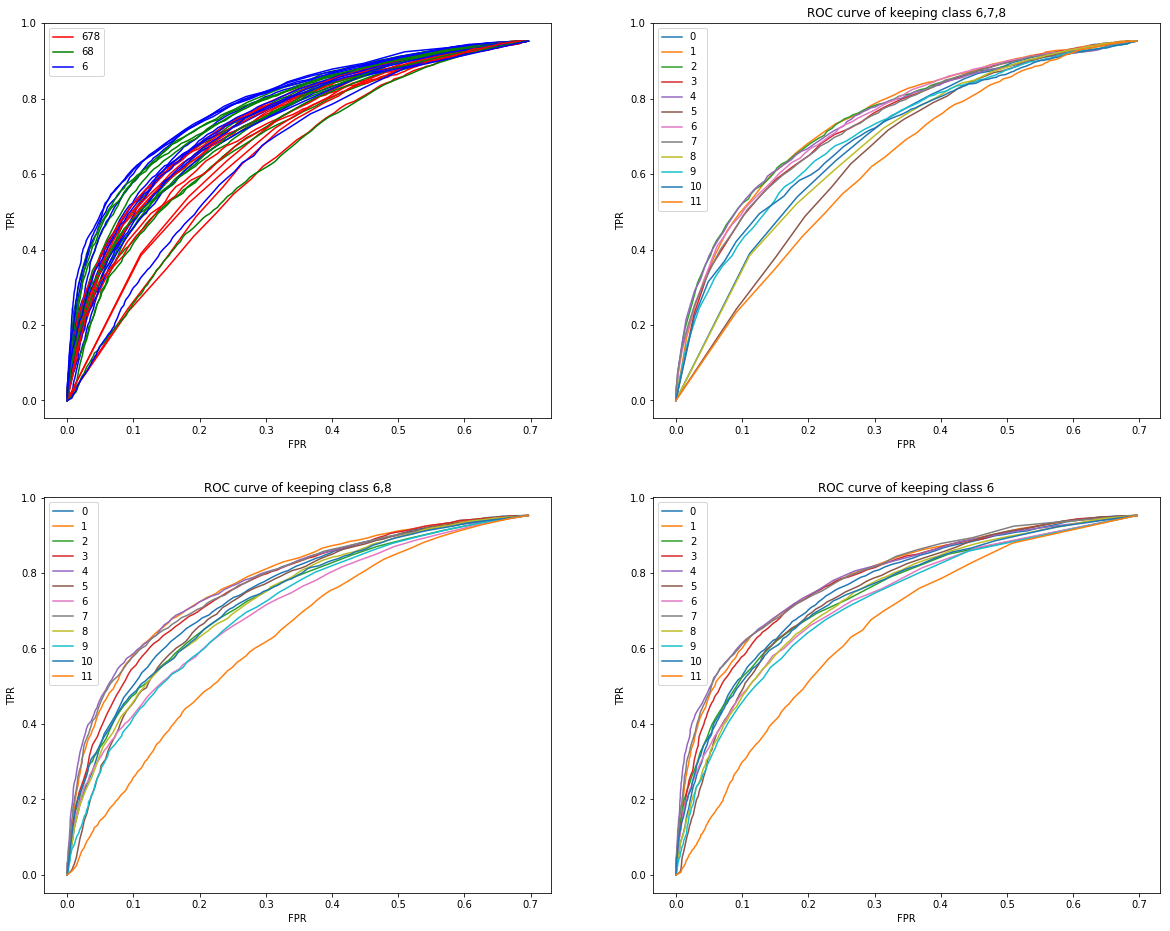


0: SVM:True,CNNWC:True,CNNBC:True,VOTE:1
1: SVM:True,CNNWC:True,CNNBC:True,VOTE:2
2: SVM:True,CNNWC:True,CNNBC:True,VOTE:3
3: SVM:True,CNNWC:True,CNNBC:False,VOTE:1
4: SVM:True,CNNWC:True,CNNBC:False,VOTE:2
5: SVM:True,CNNWC:False,CNNBC:True,VOTE:1
6: SVM:True,CNNWC:False,CNNBC:True,VOTE:2
7: SVM:True,CNNWC:False,CNNBC:False,VOTE:1
8: SVM:False,CNNWC:True,CNNBC:True,VOTE:1
9: SVM:False,CNNWC:True,CNNBC:True,VOTE:2
10: SVM:False,CNNWC:True,CNNBC:False,VOTE:1
11: SVM:False,CNNWC:False,CNNBC:True,VOTE:1



In [6]:
plt.subplots(2,2,figsize=(20,16))

plt.subplot(221)
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:],"b")
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:],"g")
    if i%3 == 0:
        plt.plot(roc[i,1,:],roc[i,0,:],"r")
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
plt.legend(["678","68","6"])
#plt.show()

plt.subplot(222)
for i in range(36):
    if i%3 == 0:
        plt.plot(roc[i,1,:],roc[i,0,:])
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve of keeping class 6,7,8")
plt.legend(np.arange(36))
#plt.show()

plt.subplot(223)
for i in range(36):
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:])
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve of keeping class 6,8")
plt.legend(np.arange(36))
#plt.show()

plt.subplot(224)
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:])
ax = plt.gca()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC curve of keeping class 6")
plt.legend(np.arange(36))

plt.show()
print("""
0: SVM:True,CNNWC:True,CNNBC:True,VOTE:1
1: SVM:True,CNNWC:True,CNNBC:True,VOTE:2
2: SVM:True,CNNWC:True,CNNBC:True,VOTE:3
3: SVM:True,CNNWC:True,CNNBC:False,VOTE:1
4: SVM:True,CNNWC:True,CNNBC:False,VOTE:2
5: SVM:True,CNNWC:False,CNNBC:True,VOTE:1
6: SVM:True,CNNWC:False,CNNBC:True,VOTE:2
7: SVM:True,CNNWC:False,CNNBC:False,VOTE:1
8: SVM:False,CNNWC:True,CNNBC:True,VOTE:1
9: SVM:False,CNNWC:True,CNNBC:True,VOTE:2
10: SVM:False,CNNWC:True,CNNBC:False,VOTE:1
11: SVM:False,CNNWC:False,CNNBC:True,VOTE:1
""")

In [99]:
tp,fn,fp,tn = vote(yhats,targets,svm=False,cnn=False,cnnwc=False,cnnbc=False,minvote=0,keptRange=[6,8],lim=0,ret=True)
print(tp)
print(fn)
print(fp)
print(tn)

2928.0
284.0
3621.0
1122.0


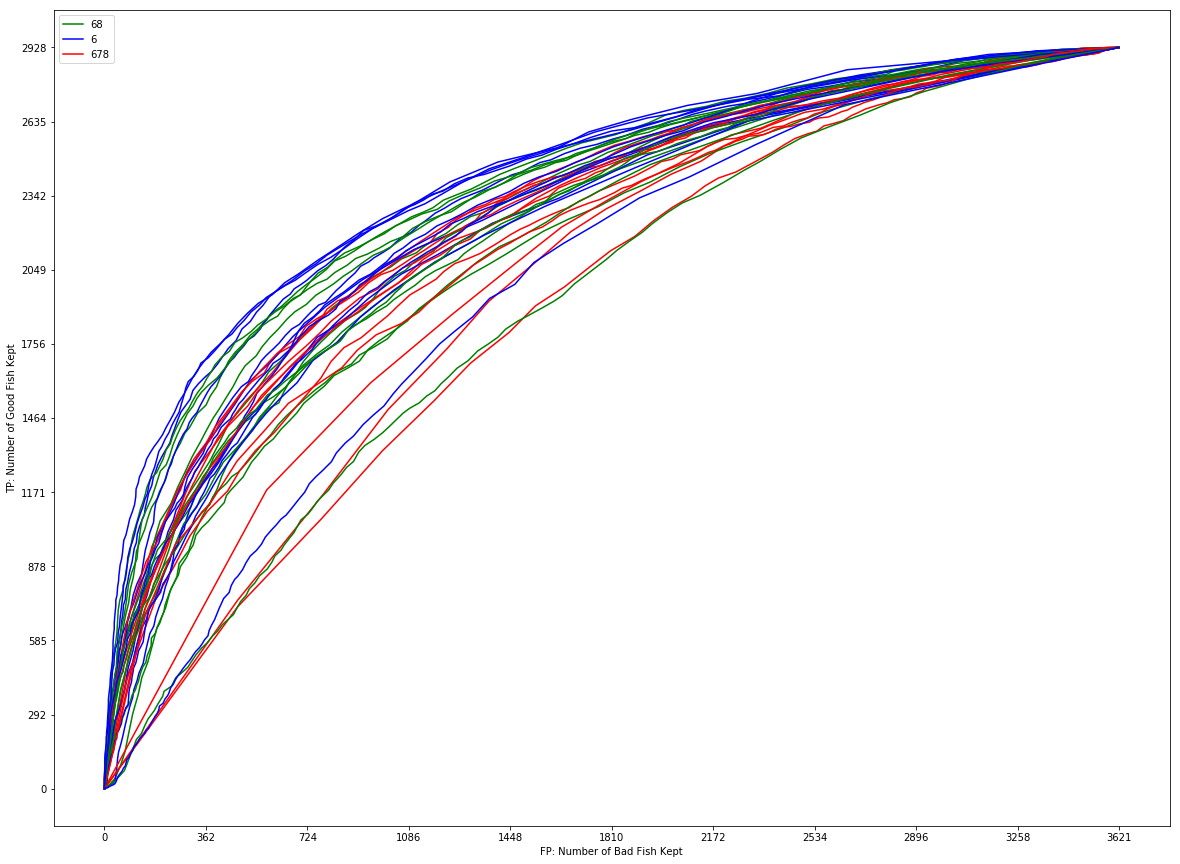

In [70]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")
roc = roc / np.array([0.95267746,0.69639469]).reshape((1,2,1))

#print(roc.shape)

plt.figure(figsize=(20,15))
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:],c="b",alpha=1)
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:],c="g",alpha=1)
    if i%3 == 0 and i != 0:
        plt.plot(roc[i,1,:],roc[i,0,:],c="r",alpha=1)
    
        
ax = plt.gca()
ax.set_xlabel("FP: Number of Bad Fish Kept")
ax.set_ylabel("TP: Number of Good Fish Kept")
#ax.set_title("ROC curve of keeping class 6,8")

titles = ["Class used: [6,7,8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6,  8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:1",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Other classifiers"]

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels((np.arange(0,1.1,0.1) * 3621).astype(int))
ax.set_yticklabels((np.arange(0,1.1,0.1) * 2928).astype(int))
plt.legend(["68","6","678"])

plt.show()

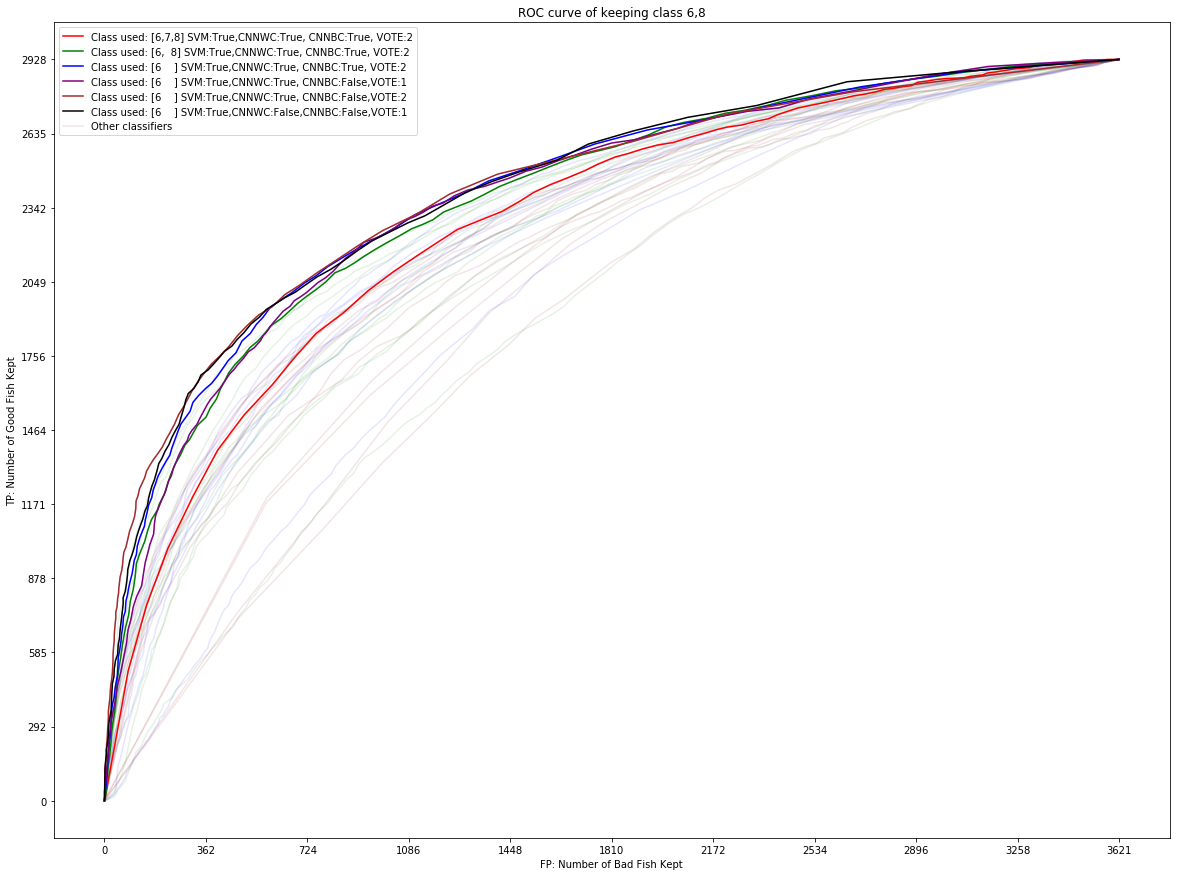

In [64]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")
roc = roc / np.array([0.95267746,0.69639469]).reshape((1,2,1))

#print(roc.shape)

plt.figure(figsize=(20,15))
for i in range(36):
    if i%3 == 2:
        plt.plot(roc[i,1,:],roc[i,0,:],c="b",alpha=0.1)
    if i%3 == 1:
        plt.plot(roc[i,1,:],roc[i,0,:],c="g",alpha=0.1)
    if i%3 == 0 and i != 0:
        plt.plot(roc[i,1,:],roc[i,0,:],c="darkred",alpha=0.1)
    
for i in range(36):
    if i == 0:
        m, = plt.plot(roc[i,1,:],roc[i,0,:],"darkred",alpha=0.1)
    
    if i == 1*3+0:
        a1, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
#     if i == 3*3+0:
#         a3, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
#     if i == 4*3+0:
#         a4, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
#     if i == 6*3+0:
#         a6, = plt.plot(roc[i,1,:],roc[i,0,:],"r")

    if i == 1*3+1:
        b1, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
#     if i == 3*3+1:
#         b3, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
#     if i == 4*3+1:
#         b4, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
#     if i == 7*3+1:
#         b7, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
    
    if i == 1*3+2:
        c1, = plt.plot(roc[i,1,:],roc[i,0,:],"blue")
    if i == 3*3+2:
        c3, = plt.plot(roc[i,1,:],roc[i,0,:],"purple")
    if i == 4*3+2:
        c4, = plt.plot(roc[i,1,:],roc[i,0,:],"brown")
    if i == 7*3+2:
        c7, = plt.plot(roc[i,1,:],roc[i,0,:],"black")
        
ax = plt.gca()
ax.set_xlabel("FP: Number of Bad Fish Kept")
ax.set_ylabel("TP: Number of Good Fish Kept")
ax.set_title("ROC curve of keeping class 6,8")

titles = ["Class used: [6,7,8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6,  8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:1",
          "Class used: [6    ] SVM:True,CNNWC:True, CNNBC:False,VOTE:2",
          "Class used: [6    ] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Other classifiers"]

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels((np.arange(0,1.1,0.1) * 3621).astype(int))
ax.set_yticklabels((np.arange(0,1.1,0.1) * 2928).astype(int))

plt.legend(np.arange(36))

plt.legend([a1,b1,c1,c3,c4,c7,m],titles)
plt.show()

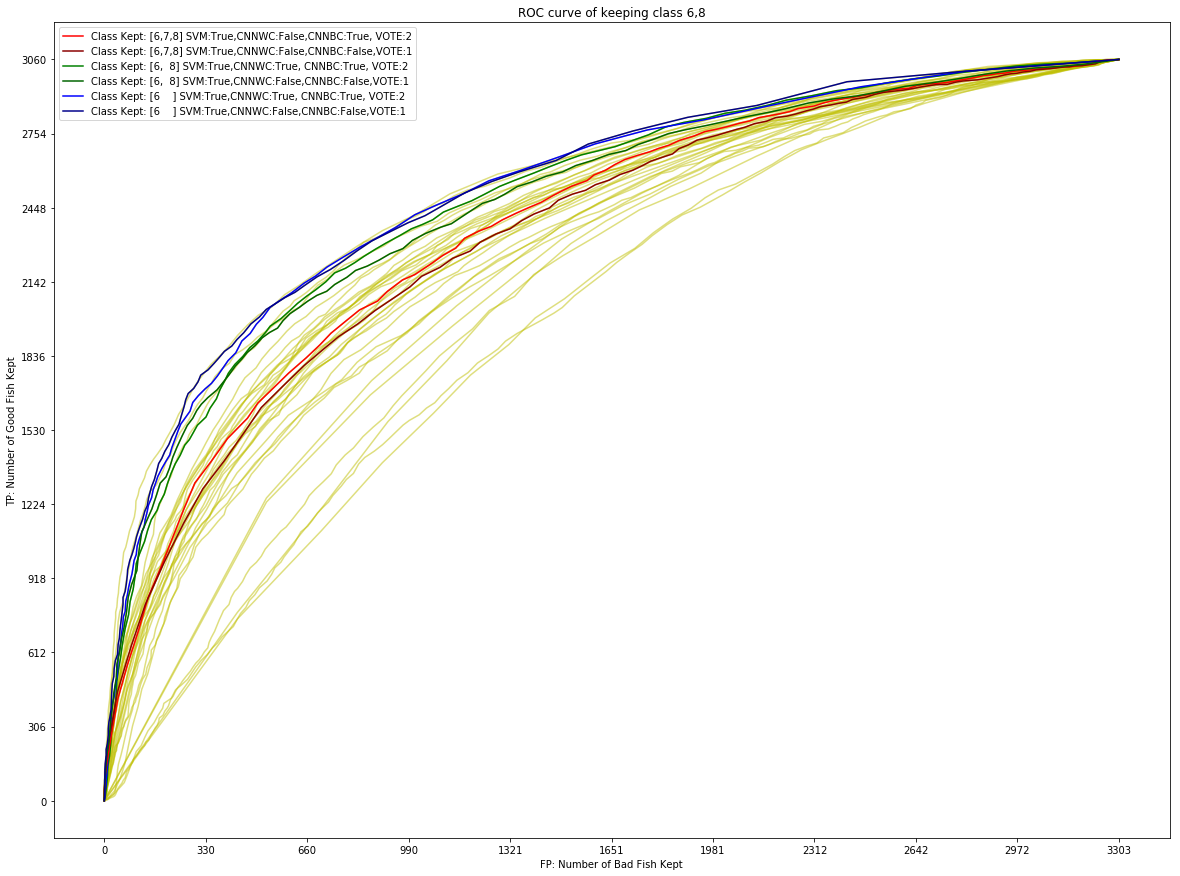

In [21]:
roc = np.load("/afs/inf.ed.ac.uk/group/project/F4KC/roc.npy")
roc = roc / np.array([0.95267746,0.69639469]).reshape((1,2,1))

#print(roc.shape)

plt.figure(figsize=(20,15))
for i in range(36):
    plt.plot(roc[i,1,:],roc[i,0,:],"y",alpha=0.5)
    
for i in range(36):
    if i == 6*3+0:
        a1, = plt.plot(roc[i,1,:],roc[i,0,:],"r")
    if i == 7*3+0:
        a2, = plt.plot(roc[i,1,:],roc[i,0,:],"darkred")
        
    if i == 1*3+1:
        a3, = plt.plot(roc[i,1,:],roc[i,0,:],"g")
    if i == 7*3+1:
        a4, = plt.plot(roc[i,1,:],roc[i,0,:],"darkgreen")
        
    if i == 1*3+2:
        a5, = plt.plot(roc[i,1,:],roc[i,0,:],"b")
    if i == 7*3+2:
        a6, = plt.plot(roc[i,1,:],roc[i,0,:],"darkblue")
        
ax = plt.gca()
ax.set_xlabel("FP: Number of Bad Fish Kept")
ax.set_ylabel("TP: Number of Good Fish Kept")
ax.set_title("ROC curve of keeping class 6,8")

titles = ["Class Kept: [6,7,8] SVM:True,CNNWC:False,CNNBC:True, VOTE:2",
          "Class Kept: [6,7,8] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Class Kept: [6,  8] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class Kept: [6,  8] SVM:True,CNNWC:False,CNNBC:False,VOTE:1",
          "Class Kept: [6    ] SVM:True,CNNWC:True, CNNBC:True, VOTE:2",
          "Class Kept: [6    ] SVM:True,CNNWC:False,CNNBC:False,VOTE:1"]

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels((np.arange(0,1.1,0.1) * 3303).astype(int))
ax.set_yticklabels((np.arange(0,1.1,0.1) * 3060).astype(int))

plt.legend([a1,a2,a3,a4,a5,a6],titles)
plt.show()

In [39]:
vote(yhats,targets,svm=True,cnn=False,cnnwc=True,cnnbc=True,minvote=2,lim=0.3,keptRange=[6,8])
vote(yhats,targets,svm=False,cnn=False,cnnwc=False,cnnbc=True,minvote=1,lim=0.3,keptRange=[6,8])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.3,keptRange=[6,8])

Using classifiers: SVM     CNN_WC CNN_BC ; Minimum vote needed: 2

Good Fish Kept: 2078; Lost: 1134;
None Fish Kept: 1602; Lost: 3141;
Accuracy: 0.656065367693
Using classifiers:                CNN_BC ; Minimum vote needed: 1

Good Fish Kept: 1559; Lost: 1653;
None Fish Kept: 1507; Lost: 3236;
Accuracy: 0.602765556254
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2085; Lost: 1127;
None Fish Kept: 1645; Lost: 3098;
Accuracy: 0.651539912005


In [68]:
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0,keptRange=[6,8])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.07,keptRange=[6,8])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.0729,keptRange=[6,8])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.08,keptRange=[6,8])
vote(yhats,targets,svm=True,cnn=False,cnnwc=False,cnnbc=False,minvote=1,lim=0.1,keptRange=[6,8])

Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 3060; Lost: 152 ;
None Fish Kept: 3303; Lost: 1440;
Accuracy: 0.565681961031
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2979; Lost: 233 ;
None Fish Kept: 2773; Lost: 1970;
Accuracy: 0.622124450031
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2972; Lost: 240 ;
None Fish Kept: 2750; Lost: 1993;
Accuracy: 0.624135763671
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2963; Lost: 249 ;
None Fish Kept: 2691; Lost: 2052;
Accuracy: 0.630421118793
Using classifiers: SVM                   ; Minimum vote needed: 1

Good Fish Kept: 2926; Lost: 286 ;
None Fish Kept: 2521; Lost: 2222;
Accuracy: 0.647140163419


In [ ]:
gamma = 0.8
time = datetime.now()
vote(yhats,targets,svm=False,cnn=False,cnnwc=False,cnnbc=False,minvote=0)
print("=================================================================")
print("    Kept Class: [6,7,8]    Sample Size: {0}    gamma: {1}".format(len(targets),gamma))
print("=================================================================")
for svm in [True,False]:
    for cnn in [False]:
        for cnnwc in [True,False]:
            for cnnbc in [True,False]:
                count = 0
                if svm   : count+=1
                if cnn   : count+=1
                if cnnwc : count+=1
                if cnnbc : count+=1
                if count == 0:continue
                for i in np.arange(1,count+1):
                    vote(yhats,targets,svm=svm,cnn=cnn,cnnwc=cnnwc,cnnbc=cnnbc,minvote=i,lim=gamma)
                    print("=================================================================")
print(datetime.now()-time)

time = datetime.now()
gamma = 0.2
print("=================================================================")
print("    Kept Class: [6,8]      Sample Size: {0}    gamma: {1}".format(len(targets),gamma))
print("=================================================================")
for svm in [True,False]:
    for cnn in [False]:
        for cnnwc in [True,False]:
            for cnnbc in [True,False]:
                count = 0
                if svm   : count+=1
                if cnn   : count+=1
                if cnnwc : count+=1
                if cnnbc : count+=1
                if count == 0:continue
                for i in np.arange(1,count+1):
                    vote(yhats,targets,svm=svm,cnn=cnn,cnnwc=cnnwc,cnnbc=cnnbc,minvote=i,keptRange=[6,8],lim=gamma)
                    print("=================================================================")
print(datetime.now()-time)

time = datetime.now()
print("=================================================================")
print("    Kept Class: [6]        Sample Size: {0}    gamma: {1}".format(len(targets),gamma))
print("=================================================================")
for svm in [True,False]:
    for cnn in [False]:
        for cnnwc in [True,False]:
            for cnnbc in [True,False]:
                count = 0
                if svm   : count+=1
                if cnn   : count+=1
                if cnnwc : count+=1
                if cnnbc : count+=1
                if count == 0:continue
                for i in np.arange(1,count+1):
                    vote(yhats,targets,svm=svm,cnn=cnn,cnnwc=cnnwc,cnnbc=cnnbc,minvote=i,keptRange=[6],lim=gamma)
                    print("=================================================================")
print(datetime.now()-time)

# Sample of FEIF fail

In [7]:
idl = np.array([396853,396857,396859,396860,396866,396876,396880,396892,396895,396900,
                    396823,396829,396843,396852,396862,396870,396882,396885,396889,396894,
                    396856,396863,396864,396868,396869,396893,396896,396897,396898,396899,
                    396624,396639,396662,396675,396728,396737,396759,396777,396790,396804,
                    396750,396760,396767,396784,396792,396793,396872,396877,396878,396886,
                    396824,396836,396839,396854,396858,396861,396865,396871,396874,396884,
                    396720,396733,396778,396815,396820,396827,396830,396834,396879,396890,
                    396840,396841,396845,396849,396850,396851,396867,396883,396887,396891,
                    396785,396802,396811,396822,396838,396844,396873,396875,396881,396888])
  
location = "/afs/inf.ed.ac.uk/group/project/F4KC/output/{0}/{1}/{2}.YHAT.npy"
start = True

for i in idl:
    idee = movs[i][0]
    length = movs_length[i]
    spacing = 1
    if length >= 200:
        spacing = length/100
    yhat = np.load(location.format(idee[0],idee[0:2],idee))
    gts = loadNewGT(idee, movs_length[i],True,spacing)
    gts = np.array(gts)
    mask = gts != None
    
    det = np.arange(len(yhat))[mask]
    
    yhat = yhat[mask]
    gts = gts[mask]
    vid = np.array([i]*len(gts))

    if start:
        yhats = yhat
        targets = gts
        vids = vid
        dets = det
        start = False
    else:
        yhats = np.vstack((yhats,yhat))
        targets = np.hstack((targets,gts))
        vids = np.hstack((vids,vid))
        dets = np.hstack((dets,det))

mask = targets != 0
yhats = yhats[mask]
targets = targets[mask]

#yhats = yhats.reshape(-1,40)
targets = targets.astype(int)

In [83]:
feif = np.sum(yhats,1)[:,6]>=3.999
class6 = targets == 6

fails = np.bitwise_and(feif,class6)

failsvideo = vids[fails]
failsdetection = dets[fails]

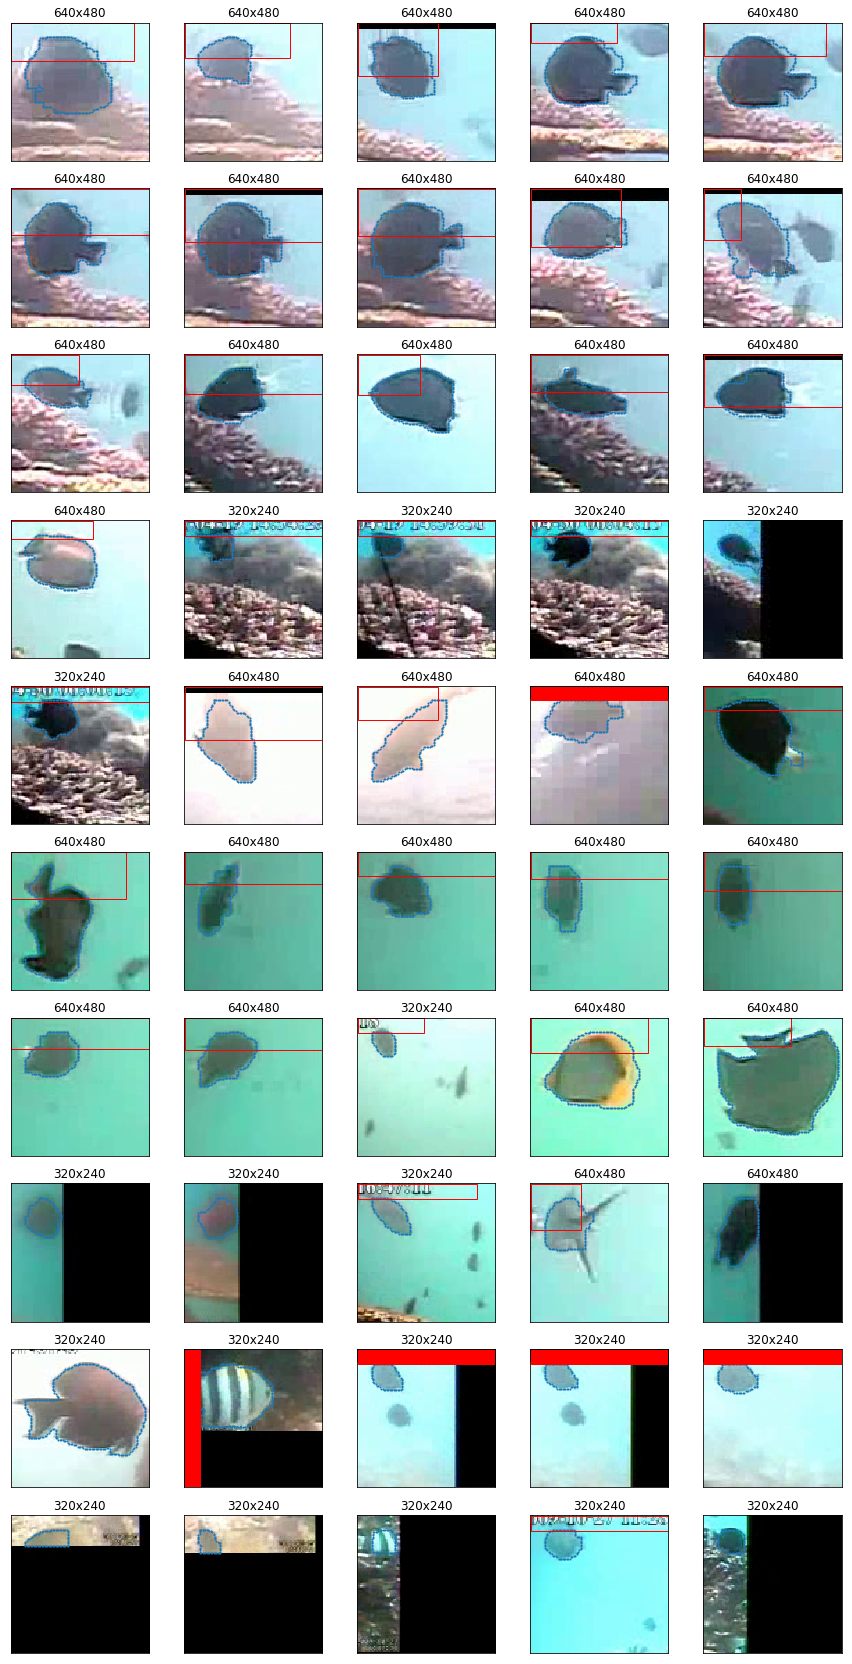

In [45]:
movs = loadMovids()
samp_vids = [343 ,638,6,5,13 ,146,408,153,408,5  ]
samp_fram = [1000,80 ,0,0,136,301,60 ,290,1  ,177]

plt.subplots(10,5,figsize=(15,30))

tsright = 266
tsbottom = 33
top = 0
right = 632
bottom = 478
left = 6

for i in np.arange(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    if movs[failsvideo[i]][2] == "1":
        plt.title("640x480")
        large = True
    else:
        plt.title("320x240")
        large = False
        
    info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
    plt.imshow(clip[failsdetection[i]])
    cline = contour[failsdetection[i]]
    thisContour, cont2 = getContour(cline, return_what="Both")
    plt.scatter(thisContour[:,0],thisContour[:,1],s=1)
    
    x,y = np.min(cont2,0)
    if large and x <= 266 and y <= 33:
        plt.gca().add_patch(patches.Rectangle((0,0),266-x+10,33-y+10,fill=False,linewidth=1,color='red'))
        
    if (not large) and x <= 163 and y <= 16:
        plt.gca().add_patch(patches.Rectangle((0,0),163-x+10,16-y+10,fill=False,linewidth=1,color='red'))
        
    if x <= 6:
        plt.gca().add_patch(patches.Rectangle((0,0),6-x+10,100,fill=True,linewidth=1,color='red'))
    if y <= 0:
        plt.gca().add_patch(patches.Rectangle((0,0),100,0-y+10,fill=True,linewidth=1,color='red'))
plt.show()

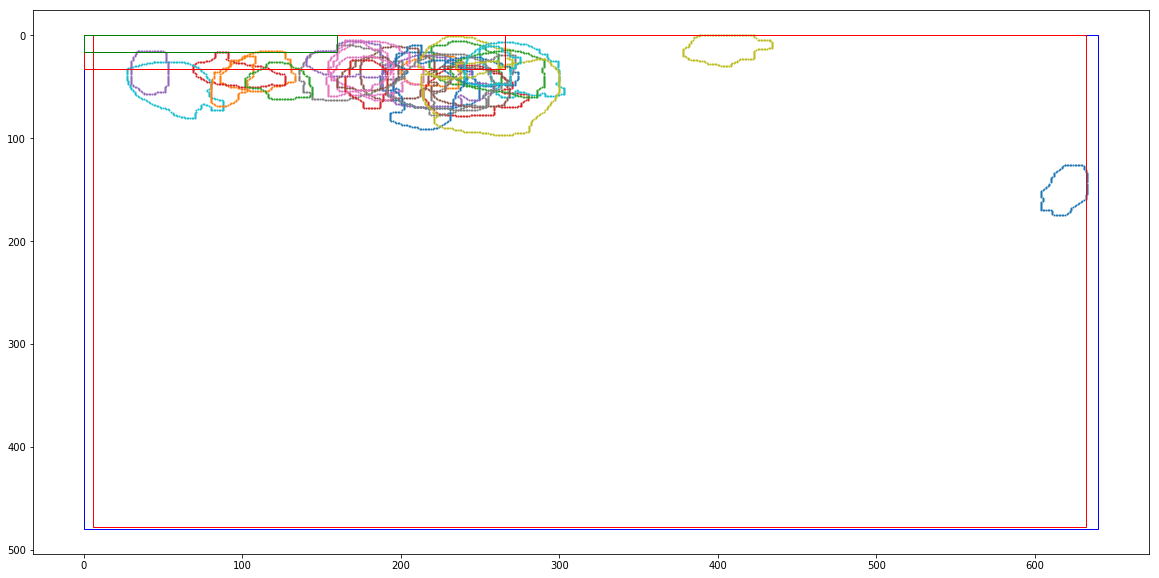

In [43]:
plt.figure(figsize=(20,10))
tsright = 266
tsbottom = 33
top = 0
right = 632
bottom = 478
left = 6
plt.gca().invert_yaxis()

plt.gca().add_patch(patches.Rectangle((0,0),640,480,fill=False,linewidth=1,color='blue'))
plt.gca().add_patch(patches.Rectangle((0,0),266,33,fill=False,linewidth=1,color='red'))
plt.gca().add_patch(patches.Rectangle((6,0),626,478,fill=False,linewidth=1,color='red'))
plt.gca().add_patch(patches.Rectangle((0,0),160,16,fill=False,linewidth=1,color='green'))

for i in np.arange(50):
    if movs[failsvideo[i]][2] == "1":
        
        info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
        cline = contour[failsdetection[i]]
        thisContour, cont2 = getContour(cline, return_what="Both")
        plt.scatter(cont2[:,0],cont2[:,1],s=1)
    
plt.show()

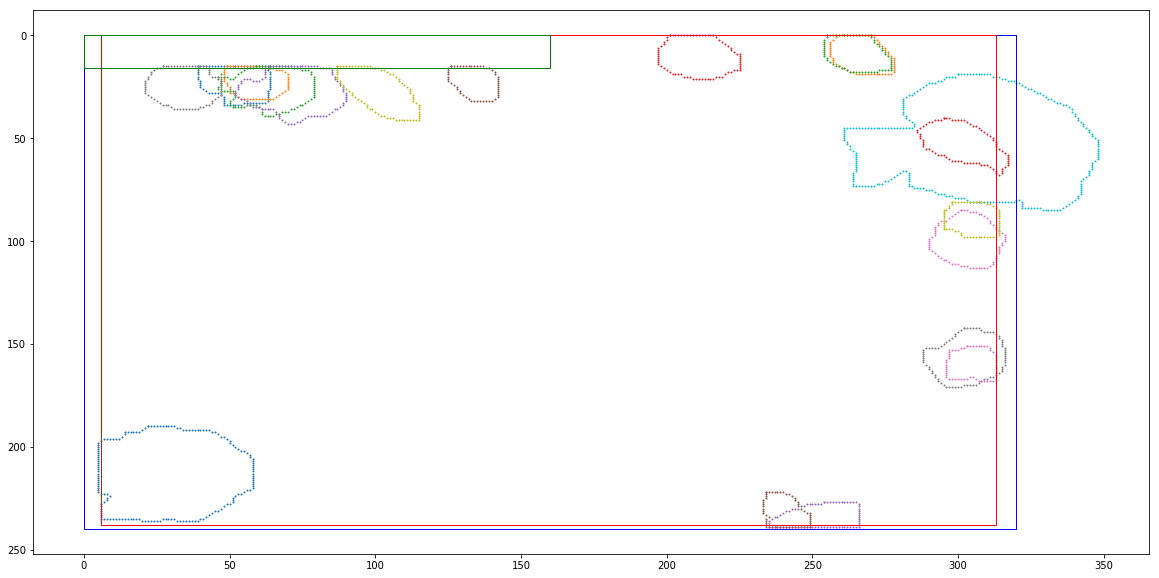

In [85]:
plt.figure(figsize=(20,10))
tsright = 266
tsbottom = 33
top = 0
right = 632
bottom = 478
left = 6
plt.gca().invert_yaxis()

plt.gca().add_patch(patches.Rectangle((0,0),320,240,fill=False,linewidth=1,color='blue'))
plt.gca().add_patch(patches.Rectangle((6,0),307,238,fill=False,linewidth=1,color='red'))
plt.gca().add_patch(patches.Rectangle((0,0),160,16,fill=False,linewidth=1,color='green'))

for i in np.arange(50):
    if movs[failsvideo[i]][2] == "0":
        
        info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
        cline = contour[failsdetection[i]]
        thisContour, cont2 = getContour(cline, return_what="Both")
        plt.scatter(cont2[:,0],cont2[:,1],s=1)
    
plt.show()

In [79]:
l = len(targets)
binary = [False] * l

for i in range(l):
    binary[i] = getWeightedVote(yhats[i,0,:],keptRange=[6,8],lim=0.0729)

binary = np.bitwise_not(np.array(binary))
class6 = targets == 6
feif = np.sum(yhats,1)[:,6]>=3.999

fails = np.bitwise_and(binary,class6)
fails = np.bitwise_and(fails,np.bitwise_not(feif))

failsvideo = vids[fails]
failsdetection = dets[fails]

In [80]:
print(np.sum(fails))

74


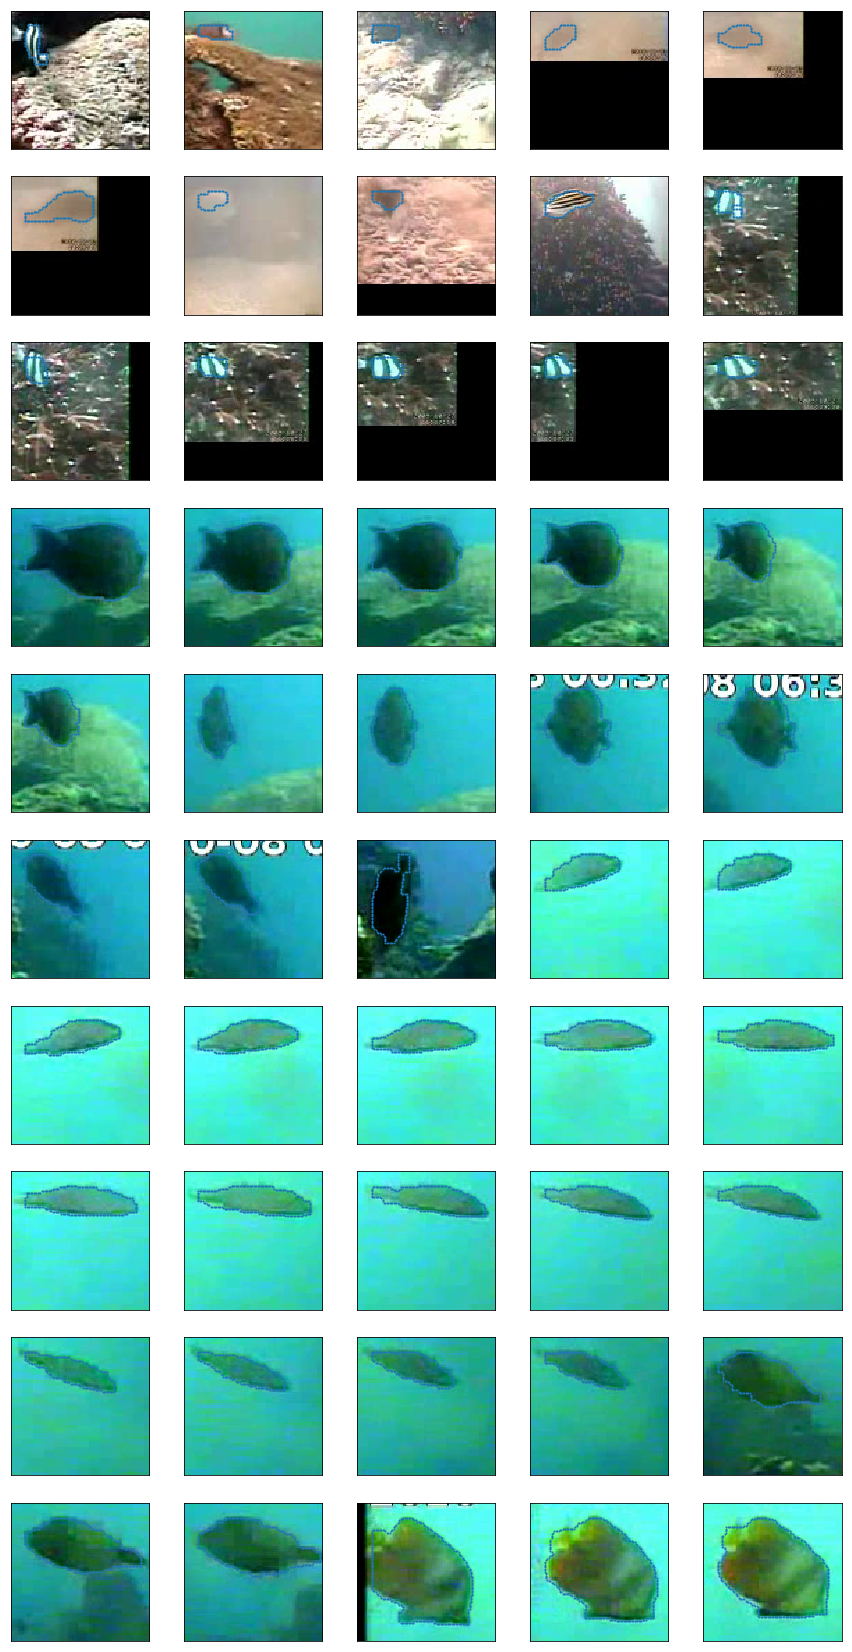

In [81]:
plt.subplots(10,5,figsize=(15,30))

for i in np.arange(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
        
    info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[failsvideo[i]])
    plt.imshow(clip[failsdetection[i]])
    cline = contour[failsdetection[i]]
    thisContour, cont2 = getContour(cline, return_what="Both")
    plt.scatter(thisContour[:,0],thisContour[:,1],s=1)
    
plt.show()

In [73]:
image_name = "/afs/inf.ed.ac.uk/user/s14/s1413557/Desktop/FEIF fails3"

image = cv2.imread(image_name + '.png')
cv2.imwrite("/afs/inf.ed.ac.uk/user/s14/s1413557/Desktop/FEIF fails3.jpg",image)

True

# RFC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

yhats, targets = getValidationResult(split=1)
yhats[yhats<0.4] = 0
rf = DecisionTreeClassifier().fit(yhats,targets)
#rf = RandomForestClassifier(n_estimators=100,n_jobs=4).fit(yhats,targets)
yhats2, targets2 = getValidationResult(split=2)
pred = rf.predict(yhats2)

cm = confusion_matrix(targets2,pred,labels=np.arange(1,11))
plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.heatmap(cm,xticklabels=np.arange(1,11), yticklabels=np.arange(1,11),annot=True,fmt='.0f')
plt.xlabel("RF Prediction")
plt.ylabel("True GT")
plt.subplot(122)
cm = cm*1.0/np.sum(cm,1).reshape(10,1)
sns.heatmap(cm,xticklabels=np.arange(1,11), yticklabels=np.arange(1,11),annot=True,fmt='.2f')
plt.xlabel("RF Prediction")
plt.ylabel("True GT")
plt.show()

In [ ]:
validateResult(pred,targets2,yrange=[6,8],grange=[6,8])